## Single Shot Object Detection

- I am trying to build a YOLO (SSD) object model with raw pytorch + Fastai v2 library.
- I'm using Pascal VOC dataset ; which contains 10k images, containing about 24k annotated having 20 different Object classes.
- Each image is annotated with some number of object class labels and their cooresponding bounding boxes.

In [1]:
from fastai.vision.all import * 

`Note` : This import * is an extremely bad practice in modern Python programming. This shouldn’t be done in production.

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/home/saurav/.fastai/data/pascal_2007/train.json'),Path('/home/saurav/.fastai/data/pascal_2007/train'),Path('/home/saurav/.fastai/data/pascal_2007/test.json'),Path('/home/saurav/.fastai/data/pascal_2007/train.csv'),Path('/home/saurav/.fastai/data/pascal_2007/valid.json'),Path('/home/saurav/.fastai/data/pascal_2007/test.csv'),Path('/home/saurav/.fastai/data/pascal_2007/test'),Path('/home/saurav/.fastai/data/pascal_2007/segmentation')]

## Exploring Dataset

- Use get_annotations function to parse COCO style bounding annotations used in VOC dataset.

In [3]:
imgs, lbl_bbox = get_annotations(path/'train.json')
len(imgs) , len(lbl_bbox)

(2501, 2501)

In [4]:
imgs[1], lbl_bbox[1]

('000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

## Visualize the Dataset

#### Using matplotlib to visualize an example from training set

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects

In [6]:
img_file,img_bbox = imgs[1] , lbl_bbox[1]
img_file,img_bbox

('000017.jpg',
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']))

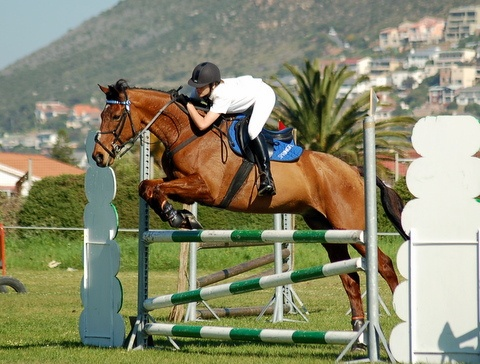

In [7]:
# load image
img = Image.open(path/f'train/{img_file}')
img

In [8]:
h,w = img.shape
h,w   # height and width of the image

(364, 480)

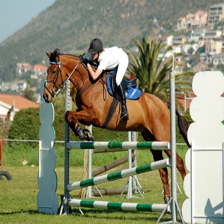

In [9]:
# rescale the image by squishing
size=224
img_scaled = img.resize((size,size))
img_scaled

In [10]:
# calculate how much we've scaled each dimension of the image
yscale,xscale = h/size , w/size
yscale, xscale

(1.625, 2.142857142857143)

In [11]:
# apply the same scale factor to each coordinates of the bounding box
img_bbox_scaled = [[x1//xscale,y1//yscale,x2//xscale,y2//yscale] for x1,y1,x2,y2 in img_bbox[0]]
img_bbox_scaled

[[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]]

In [12]:
# reconstruct the labled set of bounding boxes with the scaled bounding boxes for our example
img_bbox_scaled = (img_bbox_scaled, img_bbox[1])
img_bbox_scaled

([[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]], ['person', 'horse'])

In [13]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0,224,8))
    ax.set_yticks(np.linspace(0,224,8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax
    

<Axes: >

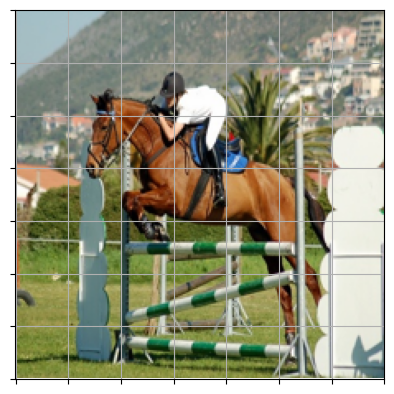

In [14]:
show_img(img_scaled)

- Create utility functions that allow to draw text on top of an image and allow us to draw a rectangle on top of an image. TO overlay class labels on top of our image in appropriate locations along with bounding boxes for each object.

In [15]:
# draw an outline around the shape; used to add contrast to the text so we can read it easily

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [16]:
# draw text in the specified location along with an outline so that there is some contrast between the text and the image
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [17]:
# a helper function to generate a set of distinct colors for visual annotations.
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [18]:
# generate a list of different colors for rendering our bounding boxes
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [19]:
# draw an image along with it's associated bounding boxes and class labels
def show_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    for i,(b,c) in enumerate(zip(lbl_bbox[0], lbl_bbox[1])):
        b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
        draw_rect(ax, b, color=colr_list[i%num_colr])
        draw_text(ax, b[:2], c, color=colr_list[i%num_colr])

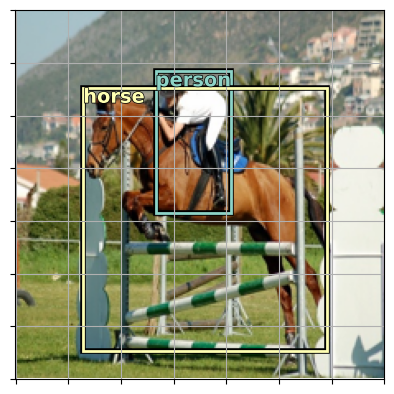

In [20]:
show_item(img_scaled,img_bbox_scaled)

## Decomposing the problem
- Create a simple model which takes an image as input and predicts just a single object class for the image.
- It'll be the largest object present in each image.

Here's a function that given a labeled bounding box sample will return the largest single bounding box along with it's class label

In [21]:
# utility function that takes a bounding box in the form of x1,y1,x2,y2 and returns it's area (w*h)
def area(b): return (b[2]-b[0])*(b[3]-b[1])

# zip the bounding boxes together with the object class; 
# sort it descending order by the size of the bounding; 
# return the first one (largest one)
def get_largest(boxes):
    return sorted(L(zip(*boxes)),key=lambda b: -area(b[0]))[0]

In [22]:
# our labled bounding box sample
img_bbox_scaled

([[85.0, 37.0, 130.0, 122.0], [41.0, 47.0, 188.0, 206.0]], ['person', 'horse'])

In [23]:
# get the largest object from our sample
get_largest(img_bbox_scaled)

([41.0, 47.0, 188.0, 206.0], 'horse')

Using a list comprehension , process all of the training metadata and produce a new training set that just contains the largest objects for each image.

In [24]:

lrg_bbox = [get_largest(boxes) for boxes in lbl_bbox]

In [25]:
img2lrgbbox = dict(zip(imgs,lrg_bbox))

In [26]:
# look at a sample from our dictionary
k = L(img2lrgbbox)[100]; k,img2lrgbbox[k]

('000431.jpg', ([31, 88, 497, 360], 'aeroplane'))

# Training a Classification Model

## Dataloaders

Using Fastai DataBlock API ,  Given a training image file name will return the full path to the image file and the class label of the largest object in that image.

In [27]:
# returns [full path to image file, largest object class name]
getters = [lambda o: path/'train'/o, lambda o: img2lrgbbox[o][1]]

In [28]:
# Try out the Datablock getter providing an image file name from our dataset (k)

k,getters[0](k),getters[1](k)

('000431.jpg',
 Path('/home/saurav/.fastai/data/pascal_2007/train/000431.jpg'),
 'aeroplane')

item_tfms will be used to make all of the dataset images the same size.
batch_tfms will be used to procedurally create more training data to improve our model performance.

In [29]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(10), Flip(), Dihedral()]  # Some basic image augmentions so that that our model get's more input image diversity during training

In [30]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

dls = dblock.dataloaders(imgs, bs = 128)

Fast AI will look at the dataset and collect all of the classes that our dataset contains which yields 20 classes as follows:

In [31]:
dls.vocab,len(dls.vocab)

(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
 20)

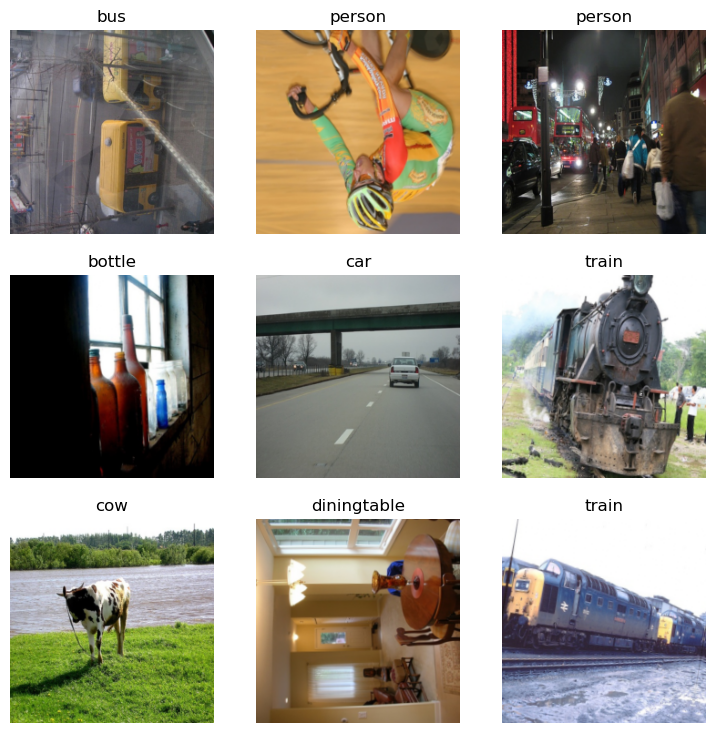

In [32]:
dls.show_batch()

Here we'll use resnet34 model which provides a pretty good mix of capacity and performance for our experiment.

In [33]:
learn = vision_learner(dls,resnet18,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/saurav/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████| 44.7M/44.7M [00:20<00:00, 2.32MB/s]


In [34]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

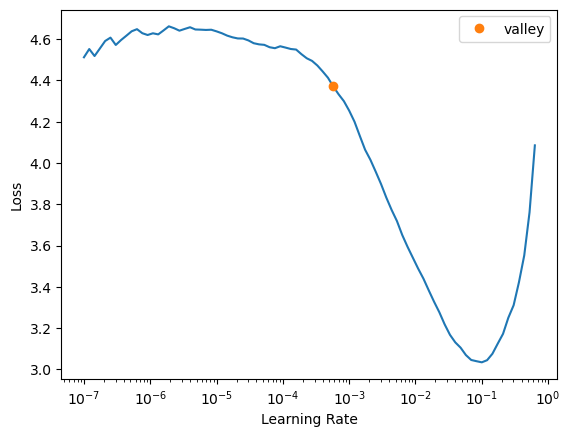

In [35]:
#finding a learning rate
lrs = learn.lr_find()

In [38]:
print(lrs.valley)

0.0005754399462603033


In [36]:
device = torch.device("cuda")

In [37]:
# Train our model (fine-tuning)
learn.fine_tune(10,base_lr=lrs.valley)


epoch,train_loss,valid_loss,accuracy,time
0,4.221928,2.089893,0.410000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,2.966910,1.674326,0.532000,00:15
1,2.699009,1.262464,0.654000,00:16
2,2.368632,1.020280,0.722000,00:16
3,2.096827,0.902305,0.748000,00:16
4,1.869151,0.842655,0.760000,00:16
5,1.684556,0.812992,0.768000,00:16
6,1.545285,0.806013,0.770000,00:16
7,1.445013,0.800129,0.778000,00:16
8,1.346071,0.798293,0.774000,00:16
9,1.292204,0.798698,0.780000,00:16


80 % accuracy is achieved.

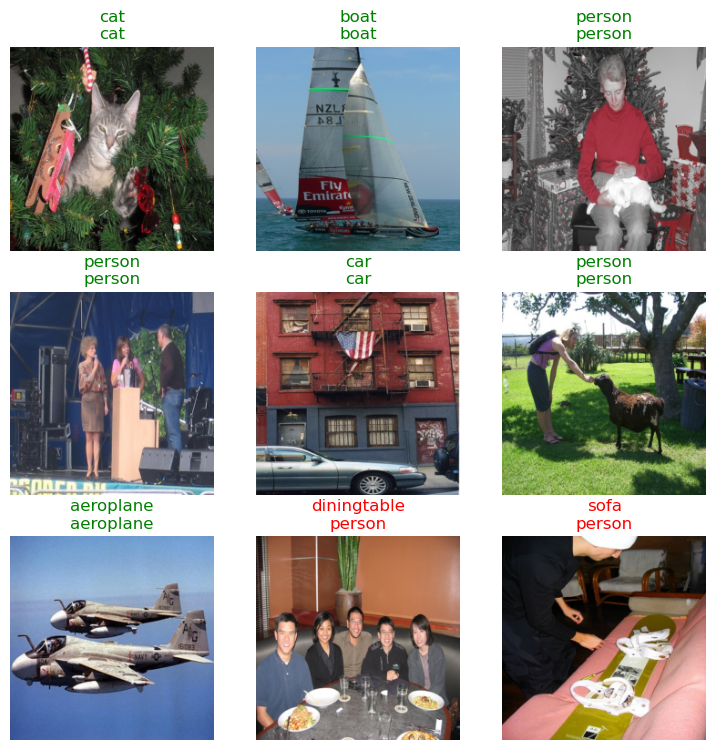

In [39]:
learn.show_results()

In [41]:
# look at a sample from our dictionary
imgs[50],lrg_bbox[50]


('000209.jpg', ([13, 75, 400, 375], 'cat'))

we have derived a "largest object dataset" which for a given image contains the largest object in the image along with it's bounding box. 

### Let's Scale Our Bounding Boxes

In [45]:
def squish_bbox(img_file,labeled_bbox):
    bbox,label = labeled_bbox
    p = path/f'train/{img_file}'
    img = Image.open(p)
    h,w = img.shape
    yscale,xscale = h/size,w/size
    scaled_bbox = (bbox[0]//xscale,bbox[1]//yscale,bbox[2]//xscale,bbox[3]//yscale)
    return [scaled_bbox,label]

In [46]:
lrg_bbox[1] # sample

([89, 77, 403, 336], 'horse')

In [47]:
squish_bbox(imgs[1], lrg_bbox[1])

[(41.0, 47.0, 188.0, 206.0), 'horse']

Lets squish to scale all the bounding coxes in our 'largest' dataset using list comprehension

In [49]:
lrg_bbox_scaled = [squish_bbox(img_file,labeled_bbox) for img_file,labeled_bbox in zip(imgs,lrg_bbox)]

Create a dict to look up the scaled boounding box and label

In [50]:
img2lrgbboxscaled = dict(zip(imgs,lrg_bbox_scaled))

In [51]:

# look at a sample from our dictionary
k = L(img2lrgbboxscaled)[1]; k,img2lrgbboxscaled[k]

('000017.jpg', [(41.0, 47.0, 188.0, 206.0), 'horse'])

### Visualize Our Bounding Box

In [54]:
# Draw image with bounding box only
def show_lrg_item(im, lbl_bbox, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax = show_img(im, ax=ax)
    b = lbl_bbox[0]
    b = (*b[:2],b[2]-b[0]+1,b[3]-b[1]+1)
    draw_rect(ax, b, color=colr_list[0])

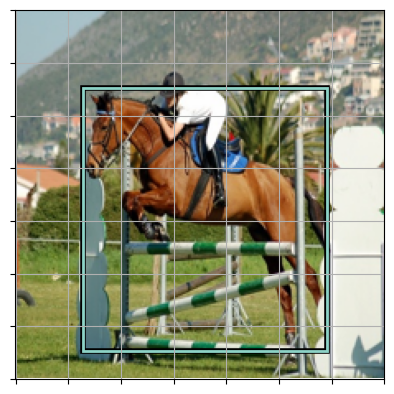

In [56]:
# Look at a sample from our dictionary

img_file = L(img2lrgbboxscaled)[1]
img_bbox_scaled = img2lrgbboxscaled[k]

img_scaled = Image.open(path/f'train/{img_file}').resize((size,size))

show_lrg_item(img_scaled,img_bbox_scaled)